In [20]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import AffinityPropagation
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler

# 1 - Data Loading

In [4]:
file_path_UMAP = "../../reduced_data/umap/embeddings/joueurs_ligue1_2024_2025_clean_per90_umap5d_best_embedding.csv"

data_UMAP = pd.read_csv(file_path_UMAP, encoding="utf-8")
print(data_UMAP.head(1))

   UMAP_1    UMAP_2     UMAP_3     UMAP_4    UMAP_5    player_name  equipe  \
0   6.495  6.823001  18.643335  11.675789 -0.964921  Jordan Lefort  Angers   

  positions   age player_id player_country_code  
0        DF  30.0  c3e4ecbb                 FRA  


In [5]:
X_UMAP = data_UMAP.drop(columns=['player_name', 'equipe', 'positions','player_id','player_country_code', 'age']).copy()

scaler = StandardScaler()
X_UMAP = scaler.fit_transform(X_UMAP) 
print(X_UMAP[1])

[ 1.54225931  0.51052202  0.04194937 -1.0814343   0.01460705]


# 2 - Clustering Methods definition

In [16]:
def run_affinity(X, damping=0.9, preference=None, random_state=42, name=""):
    aff = AffinityPropagation(damping=damping, preference=preference, random_state=random_state)
    aff.fit(X)
    labels = aff.labels_

    df = pd.DataFrame(X, columns=[f'{name}_{i+1}' for i in range(X.shape[1])])
    df["cluster"] = labels

    return df, aff


def cluster_func_affinity(X):
    df, model = run_affinity(X, damping=0.80, preference=-80, random_state=None, name="UMAP")
    labels = df["cluster"].values
    return labels, model


# 3 - Stability testing methods

In [17]:
def clustering_stability_and_consensus(X, cluster_func, n_runs=20, noise_std=0.01, sample_fraction=0.9, random_state=42):
    np.random.seed(random_state)
    n_samples = X.shape[0]
    all_labels = []
    indices_list = []

    for i in range(n_runs):
        # Échantillonnage partiel
        idx = np.random.choice(n_samples, int(sample_fraction * n_samples), replace=False)
        X_sample = X[idx, :]

        # Ajout d’un léger bruit
        X_noisy = X_sample + np.random.normal(0, noise_std, X_sample.shape)

        # Clustering
        labels, _ = cluster_func(X_noisy)
        all_labels.append(labels)
        indices_list.append(idx)

    # --- Construction de la matrice de consensus ---
    consensus_matrix = np.zeros((n_samples, n_samples))
    for run_labels, idx in zip(all_labels, indices_list):
        for i in range(len(idx)):
            for j in range(i + 1, len(idx)):
                if run_labels[i] == run_labels[j]:
                    consensus_matrix[idx[i], idx[j]] += 1
                    consensus_matrix[idx[j], idx[i]] += 1

    consensus_matrix /= n_runs

    # --- Calcul de la stabilité (ARI) ---
    stability_scores = []
    for i in range(len(all_labels)):
        for j in range(i + 1, len(all_labels)):
            common = np.intersect1d(indices_list[i], indices_list[j])
            if len(common) > 0:
                labels_i = all_labels[i][np.isin(indices_list[i], common)]
                labels_j = all_labels[j][np.isin(indices_list[j], common)]
                stability_scores.append(adjusted_rand_score(labels_i, labels_j))

    return consensus_matrix, stability_scores

# 4 - Execution du test

Stabilité moyenne (ARI) : 0.000 ± 0.005


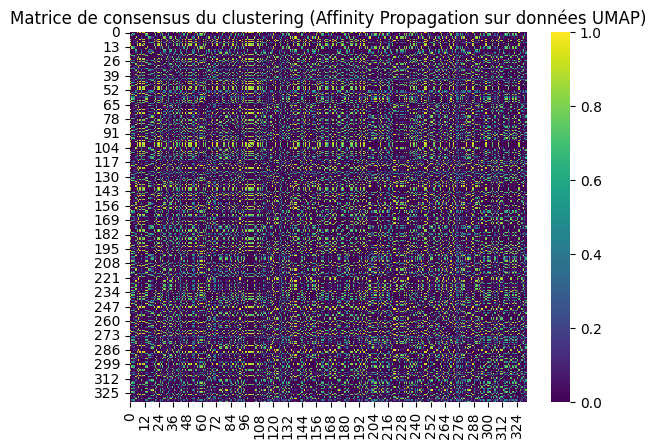

In [21]:
consensus_matrix, stability_scores = clustering_stability_and_consensus(
    X_UMAP,
    cluster_func=cluster_func_affinity,
    n_runs=15,
    noise_std=0.02,
    sample_fraction=0.9
)

print(f"Stabilité moyenne (ARI) : {np.mean(stability_scores):.3f} ± {np.std(stability_scores):.3f}")

sns.heatmap(consensus_matrix, cmap="viridis")
plt.title("Matrice de consensus du clustering (Affinity Propagation sur données UMAP)")
plt.show()